### Project Baseline Numerical Solution（MOL）

Junxiong Zhong 2025.12.7

In [1]:
# --- 变量定义与初始化 ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.integrate import solve_ivp

# 1. 空间离散化设置 
Nx = 41  # X方向节点数
Ny = 41  # Y方向节点数
X_end = 1.0 
Y_end = 1.0 

x = np.linspace(0, X_end, Nx)
y = np.linspace(0, Y_end, Ny)
X, Y = np.meshgrid(x, y)

dx = x[1] - x[0]
dy = y[1] - y[0]

# 2. 物理参数设置 =
# dθ/dτ = ∇²θ - 2Bi*θ - 2Ra*θ^4  
Bi = 1.0  # Biot Number 
Ra = 0.1  # Radiation Parameter 
Theta_a = 0.0 # 环境无量纲温度 

# 3. 时间积分设置
t_start = 0.0
t_final = 0.6  
t_eval_points = [0.10, 0.30, 0.60]

print(f"初始化完成: Grid=({Nx}x{Ny}), dx={dx:.4f}, dy={dy:.4f}")
print(f"参数设置: Bi={Bi}, Ra={Ra}")

初始化完成: Grid=(41x41), dx=0.0250, dy=0.0250
参数设置: Bi=1.0, Ra=0.1


In [2]:
# --- 定义微分方程并求解 ---

def pde_rhs(t, theta_flat):
    """
    计算 d(theta)/dt 的函数，供 solve_ivp 调用。
    输入: theta_flat (1D array)
    输出: dtheta_dt_flat (1D array)
    """
    # 1. 将 1D 向量变为 2D 网格，形状 (Ny, Nx)
    theta = theta_flat.reshape((Ny, Nx))
    
    # 初始化导数矩阵
    dtheta_dt = np.zeros_like(theta)
    
    # 2. 计算拉普拉斯算子 (Laplacian)
    # 使用二阶中心差分: (T_{i+1} - 2T_i + T_{i-1}) / dx^2
    d2_dx2 = np.zeros_like(theta)
    d2_dy2 = np.zeros_like(theta)
    
    # --- X方向导数 (d2/dx2) ---
    # 内部节点
    d2_dx2[:, 1:-1] = (theta[:, 2:] - 2*theta[:, 1:-1] + theta[:, :-2]) / dx**2
    
    # 左边界 (X=0): 绝热 -> d/dx=0 -> T_{-1} = T_{1} -> d2/dx2 = 2(T_1 - T_0)/dx^2
    d2_dx2[:, 0] = 2 * (theta[:, 1] - theta[:, 0]) / dx**2
    
    # 右边界 (X=1): 绝热 -> d/dx=0 -> T_{N} = T_{N-2} -> d2/dx2 = 2(T_{N-2} - T_{N-1}) / dx^2
    d2_dx2[:, -1] = 2 * (theta[:, -2] - theta[:, -1]) / dx**2
    
    # --- Y方向导数 (d2/dy2) ---
    # 内部节点
    d2_dy2[1:-1, :] = (theta[2:, :] - 2*theta[1:-1, :] + theta[:-2, :]) / dy**2
    
    # 顶边界 (Y=1): 绝热  -> d/dy=0 -> T_{N} = T_{N-2}
    d2_dy2[-1, :] = 2 * (theta[-2, :] - theta[-1, :]) / dy**2
    
    # 底边界 (Y=0): 恒温边界，导数将在后面强制设为0，这里先不处理或按内部算均可
    d2_dy2[0, :] = (theta[1, :] - 2*theta[0, :] + theta[0, :]) / dy**2 # 占位，会被覆盖
    
    # 总拉普拉斯项
    laplacian = d2_dx2 + d2_dy2
    
    # 3. 计算源项 (Source Terms)
    # 方程: Laplacian - 2*Bi*theta - 2*Ra*(theta^4) 
    # 注意: theta^4 可能会产生负数导致计算错误，物理上T>=0，加 abs 防止数值噪音
    radiation_term = 2 * Ra * (np.abs(theta)**4 - Theta_a**4)
    convection_term = 2 * Bi * theta
    
    dtheta_dt = laplacian - convection_term - radiation_term
    
    # 4. 执行 Dirichlet 边界条件 (底边 Y=0, Theta=1)
    #  Theta 恒定为 1，d(Theta)/dt = 0
    dtheta_dt[0, :] = 0.0
    
    # 5. 返回扁平化的 1D 向量
    return dtheta_dt.flatten()

# --- 求解过程 ---
# 初始条件: 全场为 0 
theta0 = np.zeros((Ny, Nx))
# 修正初始条件以满足边界 (底边为 1) 
theta0[0, :] = 1.0
theta0_flat = theta0.flatten()

print("开始求解 ODE 系统")

# 使用 'BDF' ，Backward Differentiation Formula
sol = solve_ivp(
    fun=pde_rhs,
    t_span=(t_start, t_final),
    y0=theta0_flat,
    method='BDF',   # 适合刚性方程
    t_eval=t_eval_points, 
    rtol=1e-5,
    atol=1e-8
)

if sol.success:
    print("求解完成")
    print(f"输出时间点: {sol.t}")
else:
    print("求解失败:", sol.message)

开始求解 ODE 系统
求解完成
输出时间点: [0.1 0.3 0.6]


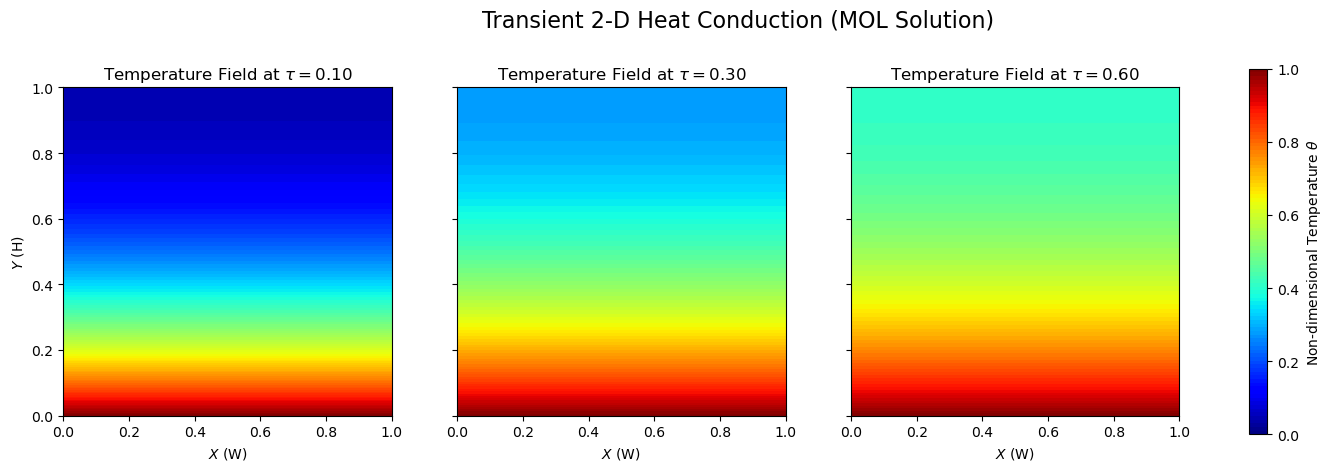

In [3]:
# --- Generate the 2-D temperature ﬁeld T(x, y, t) at three prescribed time instants: ---

# 准备绘图
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
times_to_plot = sol.t

for k, t_val in enumerate(times_to_plot):
    # 1. 提取当前时刻的解并 Reshape 回 2D
    # sol.y 的形状是 (Nx*Ny, TimeSteps)，我们取第 k 列
    theta_current = sol.y[:, k].reshape((Ny, Nx))
    
    # 2. 绘制等高线填充图 (Contourf)
    ax = axes[k]
    cf = ax.contourf(
        X,
        Y,
        theta_current,
        levels=np.linspace(0, 1, 100),  
        cmap='jet',
        norm=plt.Normalize(0, 1),
        vmin=0,
        vmax=1,
    )
    
    # 3. 格式化图表
    ax.set_title(f"Temperature Field at $\\tau = {t_val:.2f}$")
    ax.set_xlabel("$X$ (W)")
    if k == 0:
        ax.set_ylabel("$Y$ (H)")
    ax.set_aspect('equal')

# 添加统一的色标 (Colorbar)
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.95)
cbar.set_label("Non-dimensional Temperature $\\theta$")

cbar.set_ticks(np.arange(0, 1.001, 0.2))
cbar.set_ticklabels([f"{t:.1f}" for t in np.arange(0, 1.001, 0.2)])

plt.suptitle("Transient 2-D Heat Conduction (MOL Solution)", fontsize=16)
plt.savefig("MOL_2D_Temperature_Field.png")
plt.show()

提取中线数据: X索引=20 (X=0.50), Y索引=20 (Y=0.50)


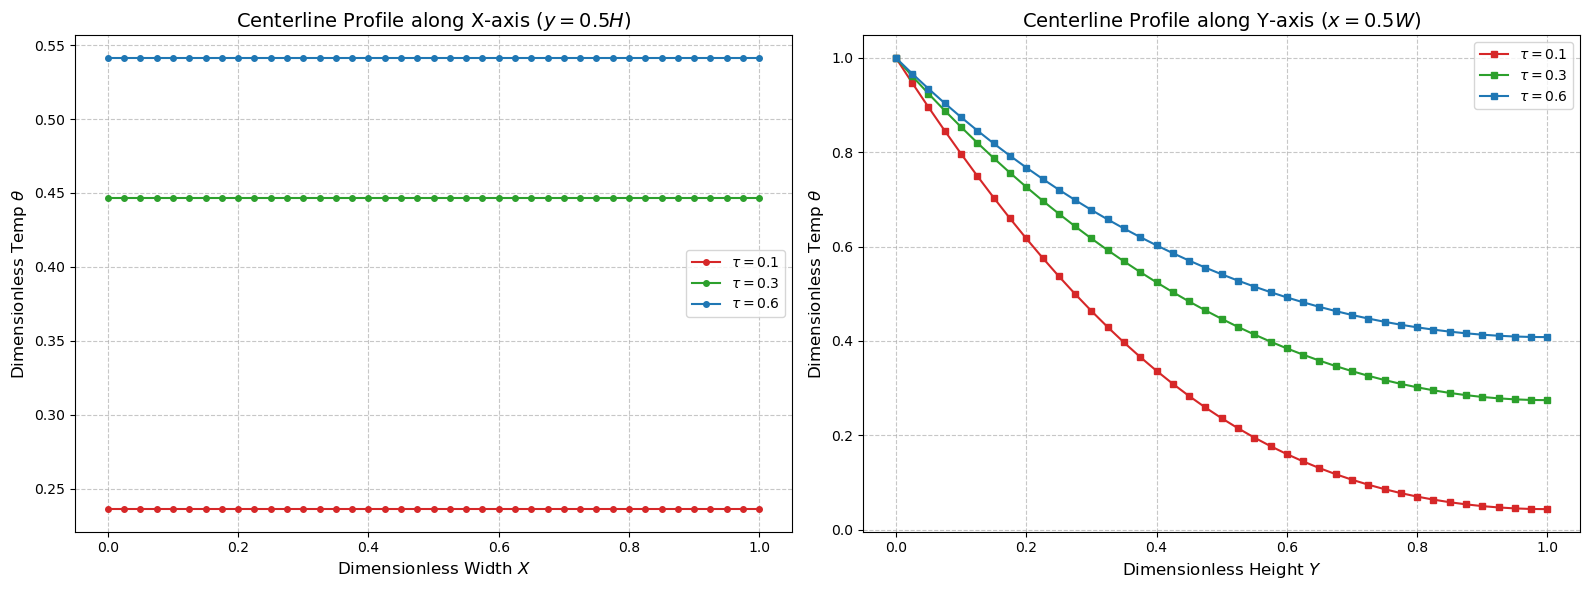

In [4]:
# --- Plot 1-D temperature proﬁles along the centerlines at the prescribed time instants ---

# 1. 确定中心节点的索引
# 由于网格是均匀分布的，且 Nx, Ny 为 41 (奇数)，中心点索引正好是整除 2
mid_x_idx = Nx // 2
mid_y_idx = Ny // 2

print(f"提取中线数据: X索引={mid_x_idx} (X={x[mid_x_idx]:.2f}), Y索引={mid_y_idx} (Y={y[mid_y_idx]:.2f})")

# 2. 绘图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
colors = ['#d62728', '#2ca02c', '#1f77b4']  # 依次对应 τ=0.1(红), 0.3(绿), 0.6(蓝)
# 遍历之前求解的三个时间点 (0.1, 0.3, 0.6)
for k, t_val in enumerate(sol.t):
    # 还原当前时刻的 2D 温度场
    theta_current = sol.y[:, k].reshape((Ny, Nx))
    
    # --- 提取数据 ---
    # 水平中线 (y=0.5H): 固定行索引 mid_y_idx，取所有列
    profile_horizontal = theta_current[mid_y_idx, :]
    
    # 垂直中线 (x=0.5W): 固定列索引 mid_x_idx，取所有行
    profile_vertical = theta_current[:, mid_x_idx]
    
    # --- 绘图 ---
    # 左图: 沿 X 轴分布 T(x, 0.5H)
    ax1.plot(x, profile_horizontal, marker='o', markersize=4, color=colors[k], label=f"$\\tau={t_val}$")
    
    # 右图: 沿 Y 轴分布 T(0.5W, y)
    ax2.plot(y, profile_vertical, marker='s', markersize=4, color=colors[k], label=f"$\\tau={t_val}$")

# 3. 图表
ax1.set_title("Centerline Profile along X-axis ($y=0.5H$)", fontsize=14)
ax1.set_xlabel("Dimensionless Width $X$", fontsize=12)
ax1.set_ylabel("Dimensionless Temp $\\theta$", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)  
ax1.legend()

ax2.set_title("Centerline Profile along Y-axis ($x=0.5W$)", fontsize=14)
ax2.set_xlabel("Dimensionless Height $Y$", fontsize=12)
ax2.set_ylabel("Dimensionless Temp $\\theta$", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)  
ax2.legend()

plt.tight_layout()
plt.savefig("MOL_1D_Temperature_Profiles.png")
plt.show()


正在重新计算密集时间步长，用于绘制平滑的历史曲线...


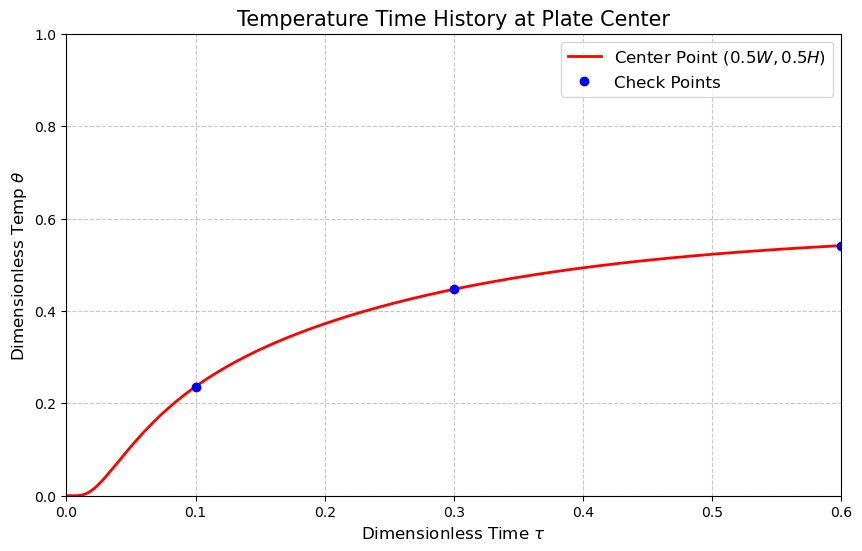

In [5]:
# --- Plot the temperature time history at the plate center ---

print("正在重新计算密集时间步长，用于绘制平滑的历史曲线...")

t_dense = np.linspace(t_start, t_final, 200) # 生成 0 到 0.6 之间的 200 个点

sol_history = solve_ivp(
    fun=pde_rhs,
    t_span=(t_start, t_final),
    y0=theta0_flat,
    method='BDF',
    t_eval=t_dense, # 请求输出这 200 个点的值
    rtol=1e-5,
    atol=1e-8
)

if sol_history.success:
    # 2. 提取中心点数据
    # 中心点在 1D 向量中的索引 = row * Nx + col
    center_flat_idx = mid_y_idx * Nx + mid_x_idx
    
    # 从解中提取该点所有时间步的温度
    # sol_history.y 的形状是 (Nx*Ny, 200)
    theta_center_history = sol_history.y[center_flat_idx, :]
    
    # 3. 绘图
    plt.figure(figsize=(10, 6))
    plt.plot(sol_history.t, theta_center_history, 'r-', linewidth=2, label='Center Point ($0.5W, 0.5H$)')

    
    # 从之前的 sol 中提取中心点温度
    theta_center_discrete = sol.y[center_flat_idx, :]
    plt.plot(sol.t, theta_center_discrete, 'bo', label='Check Points')
    
    plt.title("Temperature Time History at Plate Center", fontsize=15)
    plt.xlabel("Dimensionless Time $\\tau$", fontsize=12)
    plt.ylabel("Dimensionless Temp $\\theta$", fontsize=12)
    plt.xlim(0, 0.6)
    plt.ylim(0, 1.0) # 温度范围通常在 0 到 1 之间
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    plt.savefig("MOL_Temperature_Time_History.png")
    plt.show()
else:
    print("历史曲线求解失败:", sol_history.message)
